# Plotting the DC2 Run1.1p skyMap
<br>Owner: **Jim Chiang** ([@jchiang87](https://github.com/LSSTDESC/DC2-analysis/issues/new?body=@jchiang87))
<br>Last Verified to Run: **2018-11-11** (by @yymao)

In this notebook, we show how to use the data butler to obtain information on the skyMap used in the coadd analyses performed by the DRP pipeline.  These skyMaps are composed of tracts and patches on the sky.  Each tract is a rectangular region of the sky with a common map projection; each tract is further divided into rectangular patches, which use the same tract coordinate system and which are a convenient size for processing the coadd data.  A more complete description of the skyMap geometry is given in the HSC Software Pipeline paper ([Bosch et al. 2017](https://arxiv.org/abs/1705.06766)).

Equipped with the info from the skyMap, we plot the tracts and patches that were used with the Run1.1p processing and overlay the WFD and uDDF simulation regions.  We also use the butler to access the visit-level data and show how one can access the calexp (calibrated exposure) image data to obtain the PSF, zero-point, etc. as measured by the Stack for a given exposure.  Finally, we show how to plot the sky region imaged on the focal plane for a given visit in two ways: the first using the CCD coordinates available from the calexps and the other using the lsst_sims code to compute those coordinates from the pointing information for the visit.

## Set Up

In [1]:
import os
import glob
import warnings
import sqlite3
import re

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.patches as patches
%matplotlib inline

import lsst.afw.geom as afw_geom
import lsst.afw.cameraGeom as cameraGeom
import lsst.daf.persistence as dp
# The lsst_sims code issues some ignorable warnings regarding ids used for querying the object
# databases.
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    import lsst.sims.coordUtils
    from lsst.sims.catUtils.utils import ObservationMetaDataGenerator
    from lsst.sims.utils import getRotSkyPos
    
from desc_dc2_dm_data import REPOS

## Plotting Functions
First, we define some functions to plot the tract, patch, and CCD regions on the sky.  These are copied from [example code](https://github.com/yalsayyad/dm_notebooks/blob/master/desc-ssim/DESC-SSim%20Patch%20Geometry.ipynb) that Yusra AlSayyad presented at the [2017-06-29 SSim meeting](https://confluence.slac.stanford.edu/pages/viewpage.action?pageId=224461017).

In [2]:
def make_patch(vertexList, wcs=None):
    """
    Return a Path in sky coords from vertex list in pixel coords.
    
    Parameters
    ----------
    vertexList: list of coordinates
        These are the corners of the region to be plotted either in pixel coordinates or
        sky coordinates.
    wcs: lsst.afw.geom.skyWcs.skyWcs.SkyWcs [None]
        The WCS object used to convert from pixel to sky coordinates.

    Returns
    -------
    matplotlib.path.Path: The encapsulation of the vertex info that matplotlib uses to
    plot a patch.
    """
    if wcs is not None:
        skyPatchList = [wcs.pixelToSky(pos).getPosition(afw_geom.degrees)
                        for pos in vertexList]
    else:
        skyPatchList = vertexList
    verts = [(coord[0], coord[1]) for coord in skyPatchList]
    verts.append((0,0))
    codes = [Path.MOVETO,
             Path.LINETO,
             Path.LINETO,
             Path.LINETO,
             Path.CLOSEPOLY,
             ]
    return Path(verts, codes)

In [3]:
def plot_skymap_tract(skyMap, tract=0, title=None, ax=None):
    """
    Plot a tract from a skyMap.
    
    Parameters
    ----------
    skyMap: lsst.skyMap.SkyMap
        The SkyMap object containing the tract and patch information.
    tract: int [0]
        The tract id of the desired tract to plot.
    title: str [None]
        Title of the tract plot.  If None, the use `tract <id>`.
    ax: matplotlib.axes._subplots.AxesSubplot [None]
        The subplot object to contain the tract plot.  If None, then make a new one.

    Returns
    -------
    matplotlib.axes._subplots.AxesSubplot: The subplot containing the tract plot.
    """
    if title is None:
        title = 'tract {}'.format(tract)
    tractInfo = skyMap[tract]
    tractBox = afw_geom.Box2D(tractInfo.getBBox())
    tractPosList = tractBox.getCorners()
    wcs = tractInfo.getWcs()
    xNum, yNum = tractInfo.getNumPatches()

    if ax is None:
        fig = plt.figure(figsize=(12,8))
        ax = fig.add_subplot(111)

    tract_center = wcs.pixelToSky(tractBox.getCenter())\
                      .getPosition(afw_geom.degrees)
    ax.text(tract_center[0], tract_center[1], '%d' % tract, size=16,
            ha="center", va="center", color='blue')
    for x in range(xNum):
        for y in range(yNum):
            patchInfo = tractInfo.getPatchInfo([x, y])
            patchBox = afw_geom.Box2D(patchInfo.getOuterBBox())
            pixelPatchList = patchBox.getCorners()
            path = make_patch(pixelPatchList, wcs)
            patch = patches.PathPatch(path, alpha=0.1, lw=1)
            ax.add_patch(patch)
            center = wcs.pixelToSky(patchBox.getCenter())\
                        .getPosition(afw_geom.degrees)
            ax.text(center[0], center[1], '%d,%d'%(x,y), size=6,
                    ha="center", va="center")

    skyPosList = [wcs.pixelToSky(pos).getPosition(afw_geom.degrees)
                  for pos in tractPosList]
    ax.set_xlim(max(coord[0] for coord in skyPosList) + 1,
                min(coord[0] for coord in skyPosList) - 1)
    ax.set_ylim(min(coord[1] for coord in skyPosList) - 1,
                max(coord[1] for coord in skyPosList) + 1)
    ax.grid(ls=':',color='gray')
    ax.set_xlabel("RA (deg.)")
    ax.set_ylabel("Dec (deg.)")
    ax.set_title(title)
    return ax

The following function loops over the available calexps as returned by the data butler to determine which CCDs to draw.  Unfortunately, looping over those calexps using the butler is rather slow, but would be necessary if we wanted to access CCD-level information, like the PSF, from the calexps.
We include this function here for your edification, but then provide a faster function below.

In [4]:
def plot_focal_plane(butler, visit, ax, color='red'):
    """
    Plot the CCDs in the LSST focal plane using the coordinate information in the calexps.
    
    Notes
    -----
    By looping over the available calexps, we only plot the CCDs for which image data
    are available.
    
    Parameters
    ----------
    butler: lsst.daf.persistence.Butler
        The data butler serving up data from the desired repo.
    visit: int
        The visit or obsHistID number.
    ax: matplotlib.axes._subplots.AxesSubplot
        The matplotlib subplot object onto which to plot the focal plane.
    color: str ['red']
        Color to use for plotting the individual CCDs.
        
    Returns
    -------
    matplotlib.axes._subplots.AxesSubplot: The subplot object used for plotting.
    """
    # We use the `subset` method to obtain all of the `datarefs` (i.e., references to calexp
    # data in this case) that satisfy an "incomplete" dataId.   For visit-level calexp data,
    # a unique dataset would specify visit, raft, and sensor.  If we just give the visit, then
    # references to the available data for all of the CCDs would be returned.
    dataId = dict(visit=visit)
    datarefs = list(butler.subset('calexp', dataId=dataid))
    for i, dataref in enumerate(datarefs):
        calexp = dataref.get('calexp')
        # We're not going to do anything with it here, but we can get the PSF from the calexp
        # like this:
        # psf = calexp.getPsf()
        # and we can get the zero-point (in ADU) like this
        # zero_point = calexp.getCalib().getFluxMag0()
        ccd_box = afw_geom.Box2D(calexp.getBBox())
        wcs = calexp.getWcs()
        path = make_patch(ccd_box.getCorners(), wcs)
        ccd = patches.PathPatch(path, alpha=0.2, lw=1, color=color)
        ax.add_patch(ccd)
        center = wcs.pixelToSky(ccd_box.getCenter()).getPosition(afw_geom.degrees)
    return ax

The following fast version of the focal plane plotting code uses the lsst_sims package to obtain the location and orientation of the CCDs based on the pointing information for the desired visit.  That pointing information is extracted from the dithered minion_1016 OpSim db that has been prepared for DC2.  Since this code does not access the individual calexps for each CCD, it runs much faster.  However, it assumes that the obs_lsstSim package was used in the analysis of the data, and it needs to use the inferred locations of the calexp files to determine if calexp data for a given CCD is available. 

In [5]:
def plot_focal_plane_fast(butler, visit, ax, color='red', opsimdb=None):
    """
    Plot the CCDs in the LSST focal plane using CCD coordinates derived from the pointing
    info using the lsst.sims code.  
    
    Notes
    -----
    This function assumes that the obs_lsstSims package was used to define the camera geometry 
    for the analysis of the simulated image data.

    Parameters
    ----------
    butler: lsst.daf.persistence.Butler
        The data butler serving up data from the desired repo.
    visit: int
        The visit or obsHistID number.
    ax: matplotlib.axes._subplots.AxesSubplot
        The matplotlib subplot object onto which to plot the focal plane.
    color: str ['red']
        Color to use for plotting the individual CCDs.
    opsimDb: str [None]
        Filename of the OpSim sqlite database.  If None, then the dithered opsim db for Run1.1p
        is used.

    Returns
    -------
    matplotlib.axes._subplots.AxesSubplot: The subplot object used for plotting.
    """
    if opsimdb is None:
        opsimdb = '/global/projecta/projectdirs/lsst/groups/SSim/DC2/minion_1016_desc_dithered_v4.db'
    conn = sqlite3.connect(opsimdb)
    obs_gen = ObservationMetaDataGenerator(database=opsimdb, driver='sqlite')

    # The dithered pointing info was added to the baseline minion_1016 db.  We query for the values
    # used for the desired visit.
    curs = conn.execute('''select descDitheredRA, descDitheredDec, descDitheredRotTelPos
                        from summary where obshistid={}'''.format(visit))
    ra, dec, rottelpos = [np.degrees(x) for x in curs][0]
    
    # An ObservationMetaData object used to pass the pointing info to the function in
    # lsst.sims.coordUtils that provides the CCD coordinates.
    obs_md = obs_gen.getObservationMetaData(obsHistID=visit, boundType='circle', boundLength=0.1)[0]
    obs_md.pointingRA = ra
    obs_md.pointingDec = dec
    obs_md.OpsimMetaData['rotTelPos'] = rottelpos

    # Convert the rotation angle of the sky relative to the telescope to the sky angle relative to
    # the camera.
    obs_md.rotSkyPos = getRotSkyPos(ra, dec, obs_md, rottelpos)
    
    # Use the butler to get the camera appropriate for this observation.  If the data were from a
    # different camera, e.g., DECam or HSC, the corresponding camera objects with the associated
    # CCD geometries would be returned.
    camera = butler.get('camera')
    
    # Grab one of the calexps via its dataref so that we can ask for its filename and thereby infer
    # the location on disk of all of the calexps for this visit.
    dataref = list(butler.subset('calexp', visit=visit))[0]
    calexp_path = os.path.dirname(os.path.dirname(dataref.get('calexp_filename')[0]))
    
    # The following code is specific to the obs_lsstSim package and how it names CCDs
    # (e.g., "R:2,2 S:1,1") and formulates the path components for writing to disk.  This
    # code would not work for a different obs_ package/camera implementation.
    
    # Re-order the CCD vertex list returned by the lsst_sims code so that a rectangle is plotted.
    corner_index = (np.array([0, 1, 3, 2]),)
    for det in camera:
        # Skip the WAVEFRONT and GUIDER CCDs
        if det.getType() != cameraGeom.SCIENCE:
            continue
        detname = det.getName()
        raft, sensor = re.match(r'R:?(\d,?\d)[_ ]S:?(\d,?\d)', detname).groups()
        raft = 'R' + raft.replace(',', '')
        sensor = 'S{}.fits'.format(sensor.replace(',', ''))
        if os.path.isfile(os.path.join(calexp_path, raft, sensor)):
            corners = np.array(lsst.sims.coordUtils.getCornerRaDec(detname, camera, obs_md))
            path = make_patch(corners[corner_index])
            ccd = patches.PathPatch(path, alpha=0.2, lw=1, color=color)
            ax.add_patch(ccd)
    
    return ax

The following function just plots the boundaries of the Run1.1p regions as described in the [Run 1.1p Specifications document](https://docs.google.com/document/d/1aQOPL9smeDlhtlwDrp39Zuu2q8DKivDaHLQX3_omwOI/edit).

In [6]:
def plot_Run1_1p_region(ax):
    """Plot the WFD and uDDF regions for Run1.1p."""
    uddf_ra = [53.764, 52.486, 52.479, 53.771, 53.764]
    uddf_dec = [-27.533, -27.533, -28.667, -28.667, -27.533]

    wfd_ra = [52.25, 52.11, 58.02, 57.87, 52.25]
    wfd_dec = [-27.25, -32.25, -32.25, -27.25, -27.25]

    ax.errorbar(wfd_ra, wfd_dec, fmt='-', color='green',
                label='protoDC2 WFD boundary')
    ax.errorbar(uddf_ra, uddf_dec, fmt='-', color='red',
                label='uDDF boundary')
    return ax

This `find_available_tract_numbers` function finds all tract numbers that are actually available.

In [7]:
def find_available_tract_numbers(butler, known_existing_tract=4851, known_existing_patch='0,0', known_existing_filter='i'):
    """
    This is a hack to search the coadd folder for the tracts that have data.
    Unfortunately, this information is not directly accessible from the data butler. 
    
    In order for this hack to work, one needs to provide a known existing tract, patch, filter. 
    """
 
    ref_path = butler.getUri('deepCoadd_forced_src', tract=known_existing_tract, patch=known_existing_patch, filter=known_existing_filter)

    ref_path, success, _ = ref_path.partition('/{}/{}'.format(known_existing_tract, known_existing_patch))
    tract_pattern = re.compile('(\d+)$')
    if not success:
        ref_path, success, _ = ref_path.partition('/{}_t{}_p{}'.format(known_existing_filter, known_existing_tract, known_existing_patch))
        tract_pattern = re.compile('\w_t(\d+)_p')
    if not success:
        raise ValueError('cannot regonize path format')

    coadd_path_subdirs = [d for d in os.listdir(ref_path) if os.path.isdir(os.path.join(ref_path, d)) and tract_pattern.match(d)]
    tract_numbers = [int(tract_pattern.match(d).groups()[0]) for d in coadd_path_subdirs]
    tracts = sorted(set(tract_numbers))
    
    return tracts

## Making the Plot
We now use the above functions to plot the tracts and patches on the sky. 

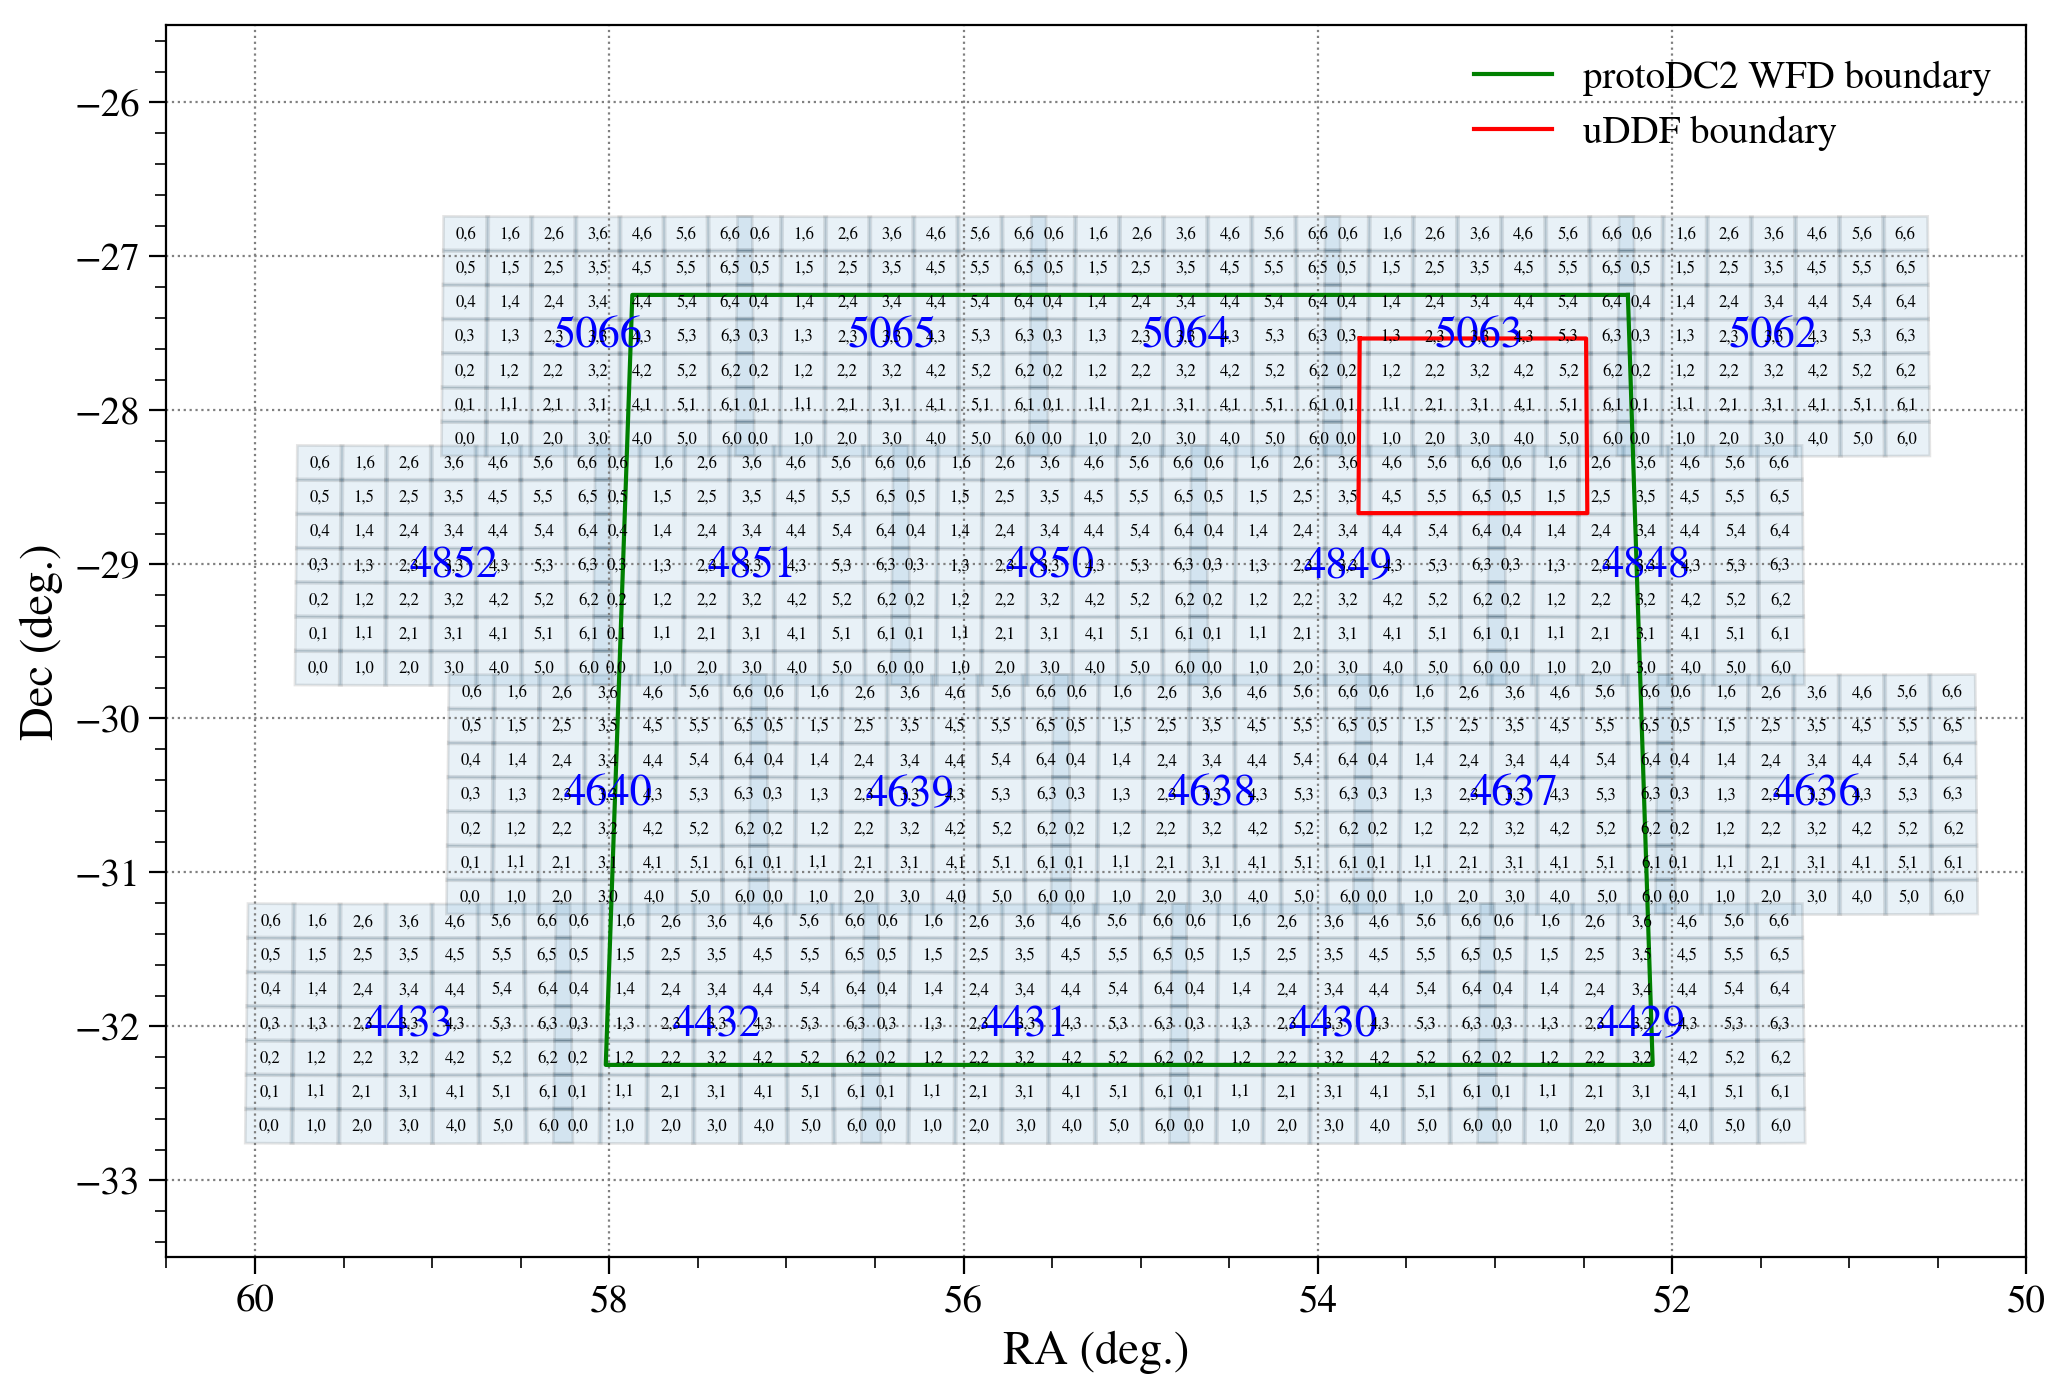

In [8]:
repo = REPOS['1.2p']
butler = dp.Butler(repo)

# First, loop over all the tracts, plotting them as gray, numbered, rectangles:
ax = None
skyMap = butler.get('deepCoadd_skyMap')
tracts = find_available_tract_numbers(butler)
for tract in tracts:
    ax = plot_skymap_tract(skyMap, tract=tract, title='', ax=ax)

# Now overlay a single focal plane, for the chosen visit, in violet:
visit = 219976
plot_focal_plane_fast(butler, visit, ax, color="violet")

# Finally, overlay the Run 1.1p main survey and uDDF regions, and then adjust the axes:
plot_Run1_1p_region(ax)

ax.set_xlim(60.5, 50.0)
ax.set_ylim(-33.5, -25.5)
plt.legend(loc=0);